# Dataset description
This dataset contains simultaneous 2-photon calcium imaging movies and loose-seal cell attached recordings of upper layer 2 pyramidal cells and interneurons of the primary visual cortex of wild type mouse, in vivo, during drifting gratings stimulus in the contralateral eye.
jGCaMP8f, jGCaMP8m, jGCaMP8s, jGCaMP7f and XCaMPgf were expressed via AAV injections using synapsin2 promoter.


Multiple neruons were recorded in each mouse, and multiple ~3-minutes-long recordings (movies/sweeps) were performed for each cell. One .nwb file contains all the data for a given cell.

#TODO Finish the description <br>
#TODO ephys, ophys, visual stim could be directly connected through tables, not just by time


### Load necessary libraries
These libraries are necessary for this script, please install if not available

In [1]:
import pynwb
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
import numpy as np
import scipy.ndimage as ndimage
%matplotlib inline

def gaussFilter(sig,sRate,sigma = .01):
    si = 1/sRate
    sig_f = ndimage.gaussian_filter(sig,sigma/si)
    return sig_f
sensor_colors ={'jGCaMP7f':'green',
                'XCaMPgf':'#0099ff',
                'jGCaMP8f':'blue',
                'jGCaMP8m':'red',
                'jGCaMP8s':'black'}

### Select Subject ID and cell number
sensor is also in the file name, please change that accordingly, use supplementary table 6 from the paper

In [2]:
sensor = 'jGCaMP8s'
subject_id = 472182
cell_number = 2

nwbfile = '/home/rozmar/Mount/HDD_RAID_2_16TB/GCaMP8_NWB/{}_ANM{}_cell{}.nwb'.format(sensor,subject_id,str(cell_number).zfill(2))
gauss_filter_sigma = 10 #ms
io = pynwb.NWBHDF5IO(nwbfile, 'r')
nwbfile = io.read()

print('Available movies are: {}'.format(list(nwbfile.imaging_planes.keys())))

Available movies are: ['Movie_0', 'Movie_1', 'Movie_2']


The .nwb file contains rich metadata about the devices, mouse, virus injection..

In [3]:
print(nwbfile)

root pynwb.file.NWBFile at 0x139745472085968
Fields:
  acquisition: {
    Raw movie 0 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Raw movie 1 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Raw movie 2 <class 'pynwb.ophys.TwoPhotonSeries'>,
    loose seal recording for movie 0 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 1 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 2 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal stimulus for movie 0 <class 'pynwb.icephys.CurrentClampStimulusSeries'>,
    loose seal stimulus for movie 1 <class 'pynwb.icephys.CurrentClampStimulusSeries'>,
    loose seal stimulus for movie 2 <class 'pynwb.icephys.CurrentClampStimulusSeries'>,
    mean images of movie 0 <class 'pynwb.base.Images'>,
    mean images of movie 1 <class 'pynwb.base.Images'>,
    mean images of movie 2 <class 'pynwb.base.Images'>
  }
  analysis: {
    responses <class 'pynwb.icephys.IntracellularResponsesTable'>
  }
  d

Select a movie from the imaging planes.

In [4]:
movie_number = 1

# Imaging plane
The imaging plane contains important metadata about the experiment, now we will use only the pixel size and frame rate in this example

In [5]:
imaging_plane = nwbfile.imaging_planes['Movie_{}'.format(movie_number)]
print(imaging_plane)
movie_pixel_size = imaging_plane.grid_spacing[0]

Movie_1 pynwb.ophys.ImagingPlane at 0x139745471795472
Fields:
  conversion: 1.0
  description: Simultaneous loose-seal recording and calcium imaging in V1
  device: MMIMS: custom-built two-photon microscope with a resonant scanner pynwb.device.Device at 0x139745473069392
  excitation_lambda: 940.0
  imaging_rate: 121.97039266980585
  indicator: jGCaMP8s
  location: V1
  optical_channel: (
    green <class 'pynwb.ophys.OpticalChannel'>
  )
  reference_frame: surface of the cortex
  unit: meters



# Ophys
The following lines show how to extract the mean image of the selected movie, the ROI and neuropil traces and the ROI and neuropil pixels. To make the data easier to interpret, we do neuropil correction, dF/F is calculated, and a gaussian filter is applied to the extracted traces. The ROI that is recorded with ephys is also labelled, it is also always the first ROI.

In [6]:
meanimage = nwbfile.acquisition['mean images of movie {}'.format(movie_number)]
mean_image_GCaMP = meanimage.images['{} at 940nm'.format(sensor)].data[:]

ophys = nwbfile.processing['ophys of movie {}'.format(movie_number)]

roi_traces = ophys['Fluorescence']['RoiResponseSeries'].data[:]
neuropil_traces = ophys['Fluorescence']['NeuropilResponseSeries'].data[:]
recorded_with_ephys = ophys['ImageSegmentation']['MovieSegmentation']['recorded_with_ephys'].data[:]
putative_cell_type = ophys['ImageSegmentation']['MovieSegmentation']['cell_type'].data[:]
roi_time = np.arange(len(roi_traces[0]))/ophys['Fluorescence']['RoiResponseSeries'].rate+ophys['Fluorescence']['RoiResponseSeries'].starting_time
roi_dff_list = []
for roi_i,(roi_trace,neuropil_trace,recorded_cell,cell_type) in enumerate(zip(roi_traces,neuropil_traces,recorded_with_ephys,putative_cell_type)):
    f_corrected = roi_trace-0.8*neuropil_trace
    f0 = np.percentile(f_corrected,20)
#    if f0<0:
#        continue
    dff = (f_corrected-f0)/f0
    dff = gaussFilter(dff,ophys['Fluorescence']['RoiResponseSeries'].rate,sigma = gauss_filter_sigma/1000)
    roi_dff_list.append(dff)  
    if recorded_cell:
        f_corrected_of_recorded_cell = f_corrected
        if cell_type == 'pyr':
            putative_cell_type = 'pyramidal cell'
        elif cell_type == 'int':
            putative_cell_type = 'interneuron'
        else:
            putative_cell_type = 'unknown'


roi_masks = ophys['ImageSegmentation']['MovieSegmentation']['image_mask'].data[:]
neuropil_masks = ophys['ImageSegmentation']['MovieSegmentation']['neuropil_mask'].data[:]

roi_image = np.zeros_like(mean_image_GCaMP)
roi_center_indices = []
for roi_i,(roi_now,neuropil_now) in enumerate(zip(roi_masks,neuropil_masks)):
    roi_image+=roi_now/np.max(roi_now)
    roi_image[neuropil_now>0] = -1*neuropil_now[neuropil_now>0]/np.max(neuropil_now)
    y_ind,x_ind = np.where(roi_now)
    roi_center_indices.append([np.median(x_ind),np.median(y_ind)])
print(ophys)

ophys of movie 1 pynwb.base.ProcessingModule at 0x139745471962832
Fields:
  data_interfaces: {
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>
  }
  description: Processing result of imaging



## Raw movie
The raw movies are chunket into multiple smaller multi-tif file. The raw movies are only linked to the .nwb file, their relative location can be accessed as followes:

In [7]:
print(nwbfile.acquisition['Raw movie {}'.format(movie_number)].external_file[:])

['movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_000.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_001.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_002.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_003.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_004.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_005.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_006.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_007.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_008.tif'
 'movie_raw/jGCaMP8s_ANM472182_cell02/movie_001/raw_009.tif']


# Ephys
The following lines show how to extract the raw electrophyisiolgy trace for the same movie selected above, the spike times and spike peak indices on the electrophysiology trace. The trace can be in current clamp or in voltage clamp recording mode. 

We stimulated the during some of the voltage clamp recordings, which can be seen on the stimulus trace, or on the artefacts of the response trace.

In [8]:
ephys = nwbfile.acquisition['loose seal recording for movie {}'.format(movie_number)]
ephys_trace = ephys.data[:]
if ephys.unit == 'volts':
    ephys_trace = ephys_trace*1000
    ephys_unit = 'mV'
else:
    ephys_trace = ephys_trace*1e12
    ephys_unit = 'pA'
ephys_time = np.arange(len(ephys_trace))/ephys.rate+ephys.starting_time
ap_times = nwbfile.analysis['responses']['ap_time'].data[:]
ap_times = ap_times[(ap_times>np.min(ephys_time)) &(ap_times<np.max(ephys_time))]
ap_indices = []
for ap_now in nwbfile.analysis['responses']['response'].data[:]:
    if ap_now[2].sweep_number==movie_number:
        ap_indices.append(ap_now[0])
ap_indices = np.asarray(ap_indices) 

print(ephys)

loose seal recording for movie 1 pynwb.icephys.CurrentClampSeries at 0x139745471796880
Fields:
  bias_current: 0.0
  bridge_balance: 0.0
  capacitance_compensation: 0.0
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (8630720,), type "<f8">
  description: no description
  electrode: Micropipette pynwb.icephys.IntracellularElectrode at 0x139745471795408
Fields:
  description: Micropipette (3–9 MOhm) filled with sterile saline containing 20 micromolar AlexaFluor 594
  device: Multiclamp 700B pynwb.device.Device at 0x139745471798160
Fields:
  description: with 20 kHz low-pass filter
  manufacturer: Axon Instruments


  gain: 0.02
  rate: 50000.0
  resolution: nan
  starting_time: 198.165999
  starting_time_unit: seconds
  stimulus_description: N/A
  sweep_number: 1
  unit: volts



# Drifting gratings visual stimulus
The information regarding the visual stimulus is in the trial field of the .nwb file. To select the visual stimuli during the selected movie, you have to use the timing of the visual stimuli.

The script below also calculates the tuning curve of the recorded neuron for this movie.

In [9]:
angle_list = []
apnum_list = []
dff_list = []
for stim_start_t_now,stim_end_t_now,a in zip(nwbfile.trials['start_time'].data[:],nwbfile.trials['stop_time'].data[:],nwbfile.trials['angle'].data[:]):
    if stim_start_t_now>roi_time[0] and stim_start_t_now<roi_time[-1]:
        angle_list.append(a)
        visual_stim_ap_num = np.sum((ap_times>stim_start_t_now)&(ap_times<stim_end_t_now))
        baseline_ap_num = np.sum((ap_times<stim_start_t_now)&(ap_times>stim_start_t_now-(stim_end_t_now-stim_start_t_now)))
        apnum_list.append(visual_stim_ap_num-baseline_ap_num)
        
        stim_start_imaging = np.argmax(roi_time>stim_start_t_now)
        if np.argmax(roi_time>stim_end_t_now)==0:  
            stim_end_imaging = len(roi_time) 
        else:  
            stim_end_imaging = np.argmax(roi_time>stim_end_t_now)
        recorded_roi_f = f_corrected_of_recorded_cell[stim_start_imaging:stim_end_imaging]
        recorded_roi_f0 = np.mean(f_corrected_of_recorded_cell[np.argmax(roi_time>stim_start_t_now-.7):np.argmax(roi_time>stim_start_t_now)])
        recorded_roi_dff = (recorded_roi_f-recorded_roi_f0)/recorded_roi_f0
        dff_list.append(np.mean(recorded_roi_dff[recorded_roi_dff>=np.percentile(recorded_roi_dff,75)]))
unique_angles = np.unique(angle_list)
dff_mean_list = []
dff_std_list = []

ap_mean_list = []
ap_std_list = []
for a in unique_angles:
    apnum_mean = np.mean(np.asarray(apnum_list)[np.asarray(angle_list)==a])
    apnum_std = np.std(np.asarray(apnum_list)[np.asarray(angle_list)==a])
    ap_mean_list.append(apnum_mean)
    ap_std_list.append(apnum_std)
    dff_mean_list.append(np.mean(np.asarray(dff_list)[np.asarray(angle_list)==a]))
    dff_std_list.append(np.std(np.asarray(dff_list)[np.asarray(angle_list)==a]))

print(nwbfile.trials)

trials pynwb.epoch.TimeIntervals at 0x139745472040336
Fields:
  colnames: ['start_time' 'stop_time' 'angle' 'cycles_per_second' 'cycles_per_degree'
 'amplitude']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    angle <class 'hdmf.common.table.VectorData'>,
    cycles_per_second <class 'hdmf.common.table.VectorData'>,
    cycles_per_degree <class 'hdmf.common.table.VectorData'>,
    amplitude <class 'hdmf.common.table.VectorData'>
  )
  description: experimental trials
  id: id <class 'hdmf.common.table.ElementIdentifiers'>



# Plot
Figures explaining the data in this .nwb file. There is more metadata in the file than what is plotted here. Please see figure legend below.

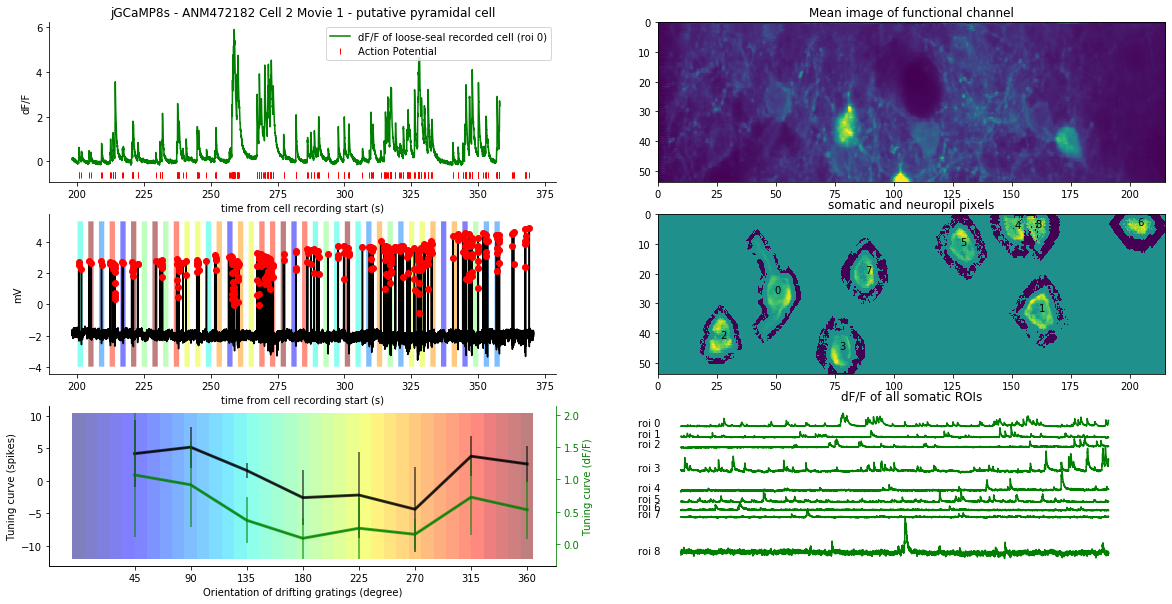

In [10]:
fig = plt.figure(figsize = [20,10])
ax_ophys_all = fig.add_subplot(3,2,6)
ax_roi_shape = fig.add_subplot(3,2,4)
ax_meanimage = fig.add_subplot(3,2,2)
ax_ophys_recorded = fig.add_subplot(3,2,1,sharex = ax_ophys_all)
ax_ephys = fig.add_subplot(3,2,3,sharex = ax_ophys_all)
ax_visual_stim = fig.add_subplot(3,2,5)
ax_visual_stim_dff = ax_visual_stim.twinx()
ax_ephys.plot(ephys_time,ephys_trace,'k-')
ax_ephys.plot(ephys_time[ap_indices],ephys_trace[ap_indices],'ro')
ax_ophys_all.axis('off')

ax_meanimage.set_title('Mean image of functional channel')
ax_ophys_all.set_title('dF/F of all somatic ROIs')
ax_roi_shape.set_title('somatic and neuropil pixels')
ax_ophys_recorded.set_title('{} - ANM{} Cell {} Movie {} - putative {}'.format(sensor,472182,cell_number,movie_number,putative_cell_type))
ax_ophys_recorded.set_ylabel('dF/F')
ax_ophys_recorded.set_xlabel('time from cell recording start (s)')
ax_ophys_recorded.spines['top'].set_visible(False)
ax_ophys_recorded.spines['right'].set_visible(False)
ax_ephys.set_ylabel('{}'.format(ephys_unit))
ax_ephys.set_xlabel('time from cell recording start (s)')
ax_ephys.spines['top'].set_visible(False)
ax_ephys.spines['right'].set_visible(False)
ax_visual_stim.set_xlabel('Orientation of drifting gratings (degree)')
ax_visual_stim.set_ylabel('Tuning curve (spikes)')
ax_visual_stim_dff.set_ylabel('Tuning curve (dF/F)')
ax_visual_stim_dff.spines['right'].set_color('green')
ax_visual_stim_dff.tick_params(axis='y', colors='green')
ax_visual_stim_dff.yaxis.label.set_color('green')
ax_visual_stim.spines['top'].set_visible(False)
ax_visual_stim.spines['right'].set_visible(False)
ax_visual_stim_dff.spines['top'].set_visible(False)

ax_meanimage.imshow(mean_image_GCaMP)
im_green = ax_meanimage.imshow(mean_image_GCaMP, extent=[0,mean_image_GCaMP.shape[1]*float(movie_pixel_size),mean_image_GCaMP.shape[0]*float(movie_pixel_size),0], aspect='auto')
clim = np.percentile(mean_image_GCaMP.flatten(),[.1,99.9])
im_green.set_clim(clim)
im_rois = ax_roi_shape.imshow(roi_image, extent=[0,roi_image.shape[1]*float(movie_pixel_size),roi_image.shape[0]*float(movie_pixel_size),0], aspect='auto')
for roi_i,center_idx in enumerate(roi_center_indices):
    ax_roi_shape.text(np.median(center_idx[0])*movie_pixel_size,np.median(center_idx[1])*movie_pixel_size,'{}'.format(roi_i))
offset = 0
for roi_i,dff in enumerate(roi_dff_list):
    offset -= np.percentile(dff,100)
    ax_ophys_all.plot(roi_time,dff+offset,'g-',alpha=1)
    ax_ophys_all.text(roi_time[0]-.1*(np.max(roi_time)-np.min(roi_time)),offset,'roi {}'.format(roi_i))
    if roi_i ==0:
        ax_ophys_recorded.plot(roi_time,dff,'g-',alpha=1,label = 'dF/F of loose-seal recorded cell (roi 0)')
        ax_ophys_recorded.plot(ap_times,np.zeros(len(ap_times))-.1*(np.max(dff)-np.min(dff)),'r|',label = 'Action Potential')
        f_corrected_of_recorded_cell = f_corrected
        ax_ophys_recorded.legend()
#%
cmap = colormap.get_cmap('jet')
ylimits_ephys = ax_ephys.get_ylim()
for stim_start_t_now,stim_end_t_now,a in zip(nwbfile.trials['start_time'].data[:],nwbfile.trials['stop_time'].data[:],nwbfile.trials['angle'].data[:]):
    if stim_start_t_now>roi_time[0] and stim_start_t_now<roi_time[-1]:
        ax_ephys.fill_between(ephys_time,
                                    ylimits_ephys[0],
                                    ylimits_ephys[1]   , 
                                    where= (ephys_time > stim_start_t_now) & (ephys_time < stim_end_t_now), 
                                    facecolor=cmap(a/360), 
                                    alpha=0.5)



ax_visual_stim.plot(unique_angles,ap_mean_list,'k-',linewidth = 3,alpha = .7)
ax_visual_stim.errorbar(unique_angles,ap_mean_list,ap_std_list,color = 'black',alpha = .7)


ax_visual_stim_dff.plot(unique_angles,dff_mean_list,'g-',linewidth = 3,alpha = .7)
ax_visual_stim_dff.errorbar(unique_angles,dff_mean_list,dff_std_list,color = 'green',alpha = .7)

y_limits_visual_stim = ax_visual_stim.get_ylim()
width = 10#np.mean(np.diff(unique_angles))*.8
for a in range(0,370,10):#unique_angles:
    ax_visual_stim.bar(a,y_limits_visual_stim,width = width,color = cmap(a/360),alpha = .5)
    
ax_visual_stim.set_xticks(unique_angles)

#io.close()

**Top left**: dF/F and action potential times (from ephys) of the loose-seal recorded neuron <br>
**Middle left**: loose-seal recording overlaid with the orientation of the drifting gratins visual stimulus. See colormap on below. Action potential peaks are highlighted with red dots. <br>
**Bottom left**: Tuning curve of the recorded cell calculated from the recording above. Black line is calculated from electrophysiology, green line is calculated from calcium imaging <br>
**Top right**: Mean image of the calcium sensor channel <br>
**Middle right**: ROI and neuropil pixels for each cell. ROI pixels are weighted by the Suite2p pipeline. Each ROI is numbered. <br>
**Bottom rigth**: dF/F for all the ROIs on the panel above.